In [4]:
import os
import glob 
import pandas as pd

pattern = os.path.join('..', 'data', 'prepared', '*.csv')
files = glob.glob(pattern)
df = pd.read_csv(files[1], sep=';')
df2 = pd.read_csv(files[0], sep=';')

def safe_int_conversion(x):
    try:
        return int(x)
    except (ValueError, TypeError):
        return None

def compute_code_insee(row):
    code_dept = safe_int_conversion(row['Code departement'])
    code_commune = safe_int_conversion(row['Code commune'])
    if code_dept is not None and code_commune is not None:
        return str((code_dept * 1000) + code_commune).zfill(5)
    return '00000'

df['Code insee'] = df.apply(compute_code_insee, axis=1)

df_data = pd.DataFrame()
cols_to_keep = [
    'Valeur fonciere',
    'Surface reelle bati', 
    'Nombre pieces principales', 
    'Surface terrain', 
    'Code insee'
]
df_data = df[cols_to_keep]

df2_data = pd.DataFrame()
col_to_keep = [
    'code_insee',
    'population',
    'superficie_km2',
    'densite',
    'altitude_moyenne',
    'latitude_centre',
    'longitude_centre',
    'niveau_equipements_services'
]
df2_data = df2[col_to_keep]

df_merged = pd.merge(df_data, df2_data, left_on='Code insee', right_on='code_insee')
df_merged.drop(columns=['code_insee'], inplace=True)
df_merged.dtypes

Valeur fonciere                  int64
Surface reelle bati              int64
Nombre pieces principales        int64
Surface terrain                  int64
Code insee                      object
population                       int64
superficie_km2                 float64
densite                        float64
altitude_moyenne                 int64
latitude_centre                float64
longitude_centre               float64
niveau_equipements_services    float64
dtype: object

In [10]:
df_merged[df_merged['Code insee'] == '75102']

,Valeur fonciere,Surface reelle bati,Nombre pieces principales,Surface terrain,Code insee,population,superficie_km2,densite,altitude_moyenne,latitude_centre,longitude_centre,niveau_equipements_services
3277,263000,25,2,0,75102,20433,99.16,206.060912,35,48.8677,2.3411,4.0
5255,270000,22,1,0,75102,20433,99.16,206.060912,35,48.8677,2.3411,4.0
7538,441000,49,0,0,75102,20433,99.16,206.060912,35,48.8677,2.3411,4.0
9308,269700,22,2,0,75102,20433,99.16,206.060912,35,48.8677,2.3411,4.0
9424,300000,26,2,0,75102,20433,99.16,206.060912,35,48.8677,2.3411,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
280529,170000,16,0,0,75102,20433,99.16,206.060912,35,48.8677,2.3411,4.0
280607,199000,16,1,0,75102,20433,99.16,206.060912,35,48.8677,2.3411,4.0
280972,690640,66,3,0,75102,20433,99.16,206.060912,35,48.8677,2.3411,4.0
281522,208800,13,1,0,75102,20433,99.16,206.060912,35,48.8677,2.3411,4.0


In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

y = df_merged['Valeur fonciere']
X = df_merged.drop(columns=['Valeur fonciere', 'Code insee', ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

mlflow.set_tracking_uri("file://" + os.path.join(os.getcwd(), "mlruns"))
mlflow.set_experiment("mon_experience_immobilier")

with mlflow.start_run():
    # On lance l'entraînement du modèle a travers un run mlflow.
    # Pour visualiser les résultats, lancer la commande "mlflow ui" dans un terminal
    # Puis aller à l'adresse http://localhost:5000

    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)

    r2 = r2_score(y_valid, preds)

    # Logger les paramètres et métriques
    mlflow.log_param("model_type", "GradientBoostingRegressor")
    mlflow.log_metric("R2", r2)
    
    # Sauvegarder le modèle
    mlflow.sklearn.log_model(model, "model")

print(f"GradientBoostingRegressor : R2={r2:.4f}")


with mlflow.start_run():
    # On lance l'entraînement du modèle a travers un run mlflow.
    # Pour visualiser les résultats, lancer la commande "mlflow ui" dans un terminal
    # Puis aller à l'adresse http://localhost:5000

    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)

    r2 = r2_score(y_valid, preds)

    # Logger les paramètres et métriques
    mlflow.log_param("model_type", "XGBRegressor")
    mlflow.log_metric("R2", r2)
    
    # Sauvegarder le modèle
    mlflow.sklearn.log_model(model, "model")
print(f"XGBRegressor : R2={r2:.4f}")



2025/10/23 11:01:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/23 11:01:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GradientBoostingRegressor : R2=0.2744


2025/10/23 11:01:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/23 11:01:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBRegressor : R2=0.1492


In [13]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

y = df_merged['Valeur fonciere']
X = df_merged.drop(columns=['Valeur fonciere', 'Code insee', ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

mlflow.set_tracking_uri("file://" + os.path.join(os.getcwd(), "mlruns"))
mlflow.set_experiment("mon_experience_immobilier")

with mlflow.start_run():
    # On lance l'entraînement du modèle a travers un run mlflow.
    # Pour visualiser les résultats, lancer la commande "mlflow ui" dans un terminal
    # Puis aller à l'adresse http://localhost:5000

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(random_state=42, learning_rate=0.1, n_estimators=100, max_depth=3))
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_valid)

    r2 = r2_score(y_valid, preds)

    # Logger les paramètres et métriques
    mlflow.log_param("model_type", "GradientBoostingRegressor")
    mlflow.log_metric("R2", r2)

    # Sauvegarder le modèle
    mlflow.sklearn.log_model(model, "model")

print(f"GradientBoostingRegressor : R2={r2:.4f}")


with mlflow.start_run():
    # On lance l'entraînement du modèle a travers un run mlflow.
    # Pour visualiser les résultats, lancer la commande "mlflow ui" dans un terminal
    # Puis aller à l'adresse http://localhost:5000
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_valid)

    r2 = r2_score(y_valid, preds)

    # Logger les paramètres et métriques
    mlflow.log_param("model_type", "XGBRegressor")
    mlflow.log_metric("R2", r2)
    
    # Sauvegarder le modèle
    mlflow.sklearn.log_model(model, "model")
print(f"XGBRegressor : R2={r2:.4f}")

''' INUTILE TROP LONG et score moins bon
with mlflow.start_run():
    # On lance l'entraînement du modèle a travers un run mlflow.
    # Pour visualiser les résultats, lancer la commande "mlflow ui" dans un terminal
    # Puis aller à l'adresse http://localhost:5000
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_valid)

    r2 = r2_score(y_valid, preds)

    # Logger les paramètres et métriques
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_metric("R2", r2)
    
    # Sauvegarder le modèle
    mlflow.sklearn.log_model(model, "model")
print(f"RandomForestRegressor : R2={r2:.4f}")
'''


2025/10/23 11:20:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/23 11:20:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GradientBoostingRegressor : R2=0.2765


2025/10/23 11:20:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/23 11:20:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBRegressor : R2=0.1709


' INUTILE TROP LONG et score moins bon\nwith mlflow.start_run():\n    # On lance l\'entraînement du modèle a travers un run mlflow.\n    # Pour visualiser les résultats, lancer la commande "mlflow ui" dans un terminal\n    # Puis aller à l\'adresse http://localhost:5000\n    pipeline = Pipeline([\n        (\'scaler\', StandardScaler()),\n        (\'model\', RandomForestRegressor(random_state=42))\n    ])\n    pipeline.fit(X_train, y_train)\n    preds = pipeline.predict(X_valid)\n\n    r2 = r2_score(y_valid, preds)\n\n    # Logger les paramètres et métriques\n    mlflow.log_param("model_type", "RandomForestRegressor")\n    mlflow.log_metric("R2", r2)\n\n    # Sauvegarder le modèle\n    mlflow.sklearn.log_model(model, "model")\nprint(f"RandomForestRegressor : R2={r2:.4f}")\n'

In [ ]:
import matplotlib.pyplot as plt

def visu_outliers(y): 

    print(f"Visualisation des outliers pour la variable {y.name}")
    # Statistiques de base
    #print(y.describe())
    print(f"\nMin: {y.min()}, Max: {y.max()}")
    print(f"Médiane: {y.median()}, Moyenne: {y.mean()}")

    # Visualiser la distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogramme
    axes[0].hist(y, bins=50, edgecolor='black')
    axes[0].set_xlabel(y.name)
    axes[0].set_ylabel('Fréquence')
    axes[0].set_title('Distribution')

    # Boxplot pour voir les outliers
    axes[1].boxplot(y)
    axes[1].set_ylabel(y.name)
    axes[1].set_title('Boxplot (outliers visibles)')

    plt.tight_layout()
    plt.show()



Visualisation des outliers pour la variable Valeur fonciere

Min: 2, Max: 124971904
Médiane: 179000.0, Moyenne: 248177.02131717716


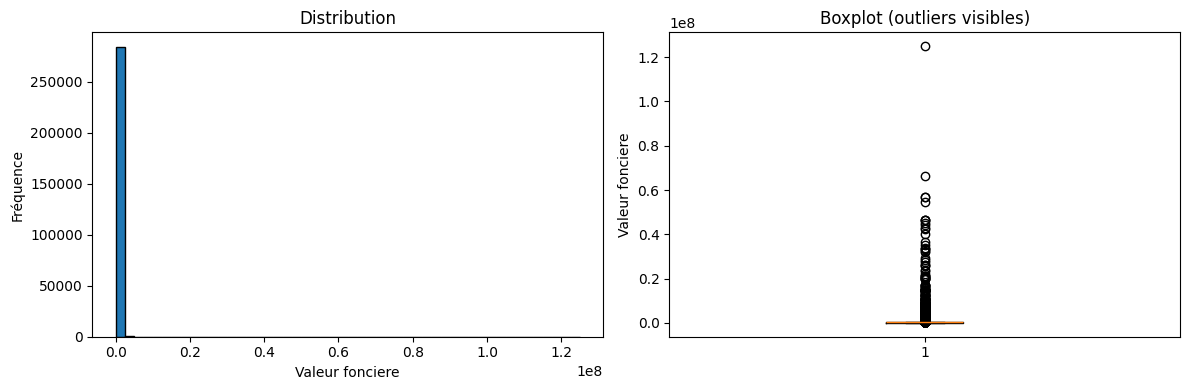

Visualisation des outliers pour la variable Surface reelle bati

Min: 1, Max: 303623
Médiane: 73.0, Moyenne: 98.79757797599012


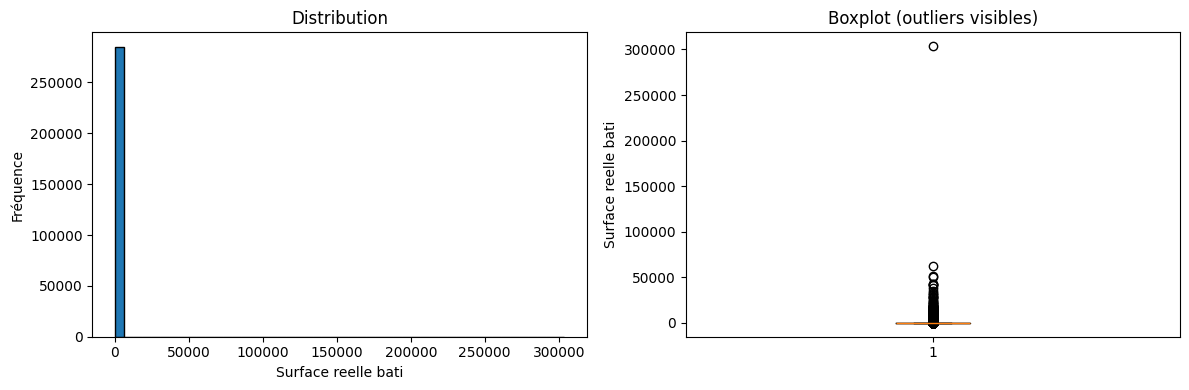

Visualisation des outliers pour la variable Nombre pieces principales

Min: 0, Max: 83
Médiane: 3.0, Moyenne: 3.191006114663974


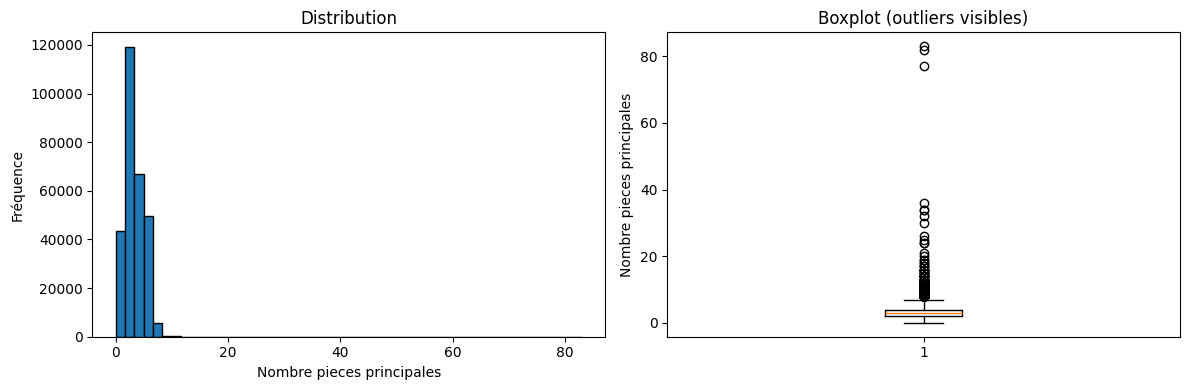

Visualisation des outliers pour la variable Surface terrain

Min: 0, Max: 263590
Médiane: 0.0, Moyenne: 280.8266541848985


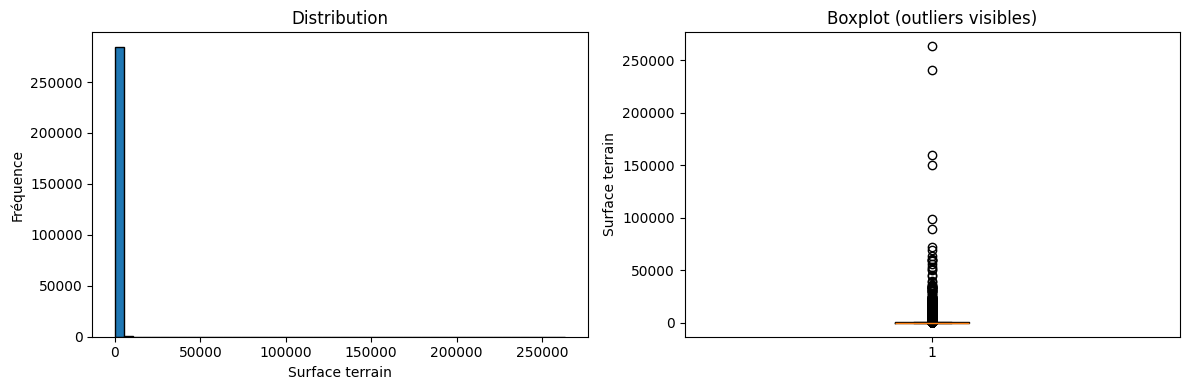

Visualisation des outliers pour la variable population

Min: 10, Max: 504078
Médiane: 14482.0, Moyenne: 50231.21704953439


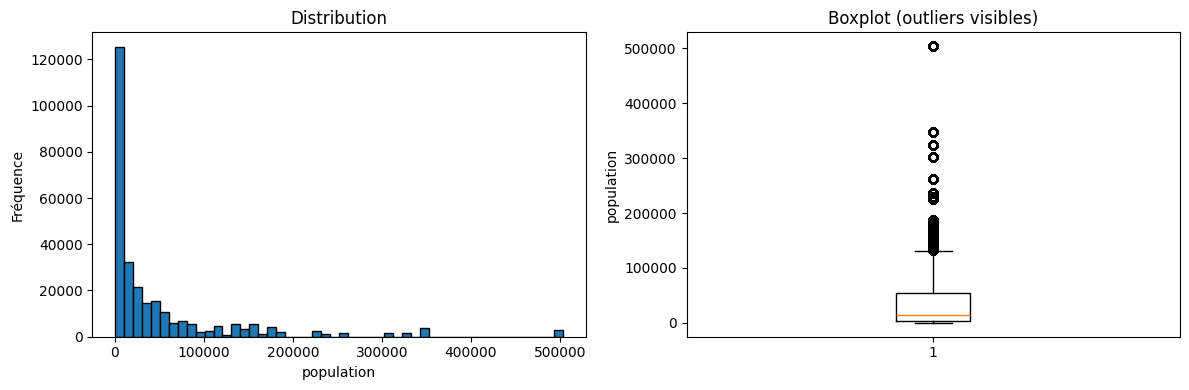

Visualisation des outliers pour la variable superficie_km2

Min: 0.0, Max: 6322.7
Médiane: 21.0, Moyenne: 87.67739422052058


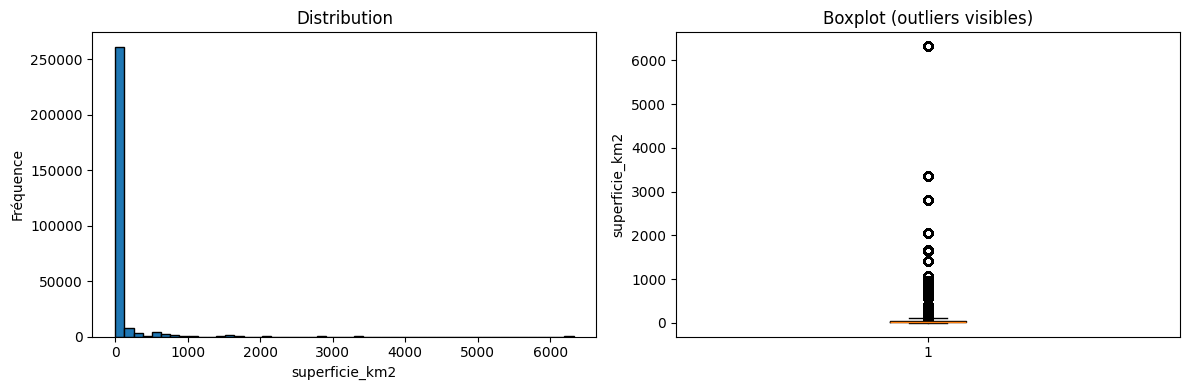

Visualisation des outliers pour la variable densite

Min: 0.0, Max: 28220.0
Médiane: 572.0, Moyenne: 1937.8779342372693


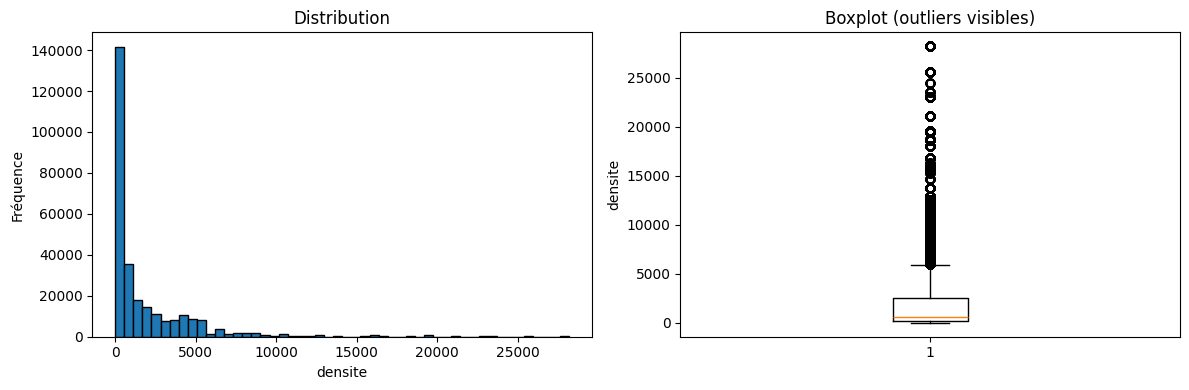

Visualisation des outliers pour la variable altitude_moyenne

Min: 0, Max: 2713
Médiane: 90.0, Moyenne: 180.44951194883876


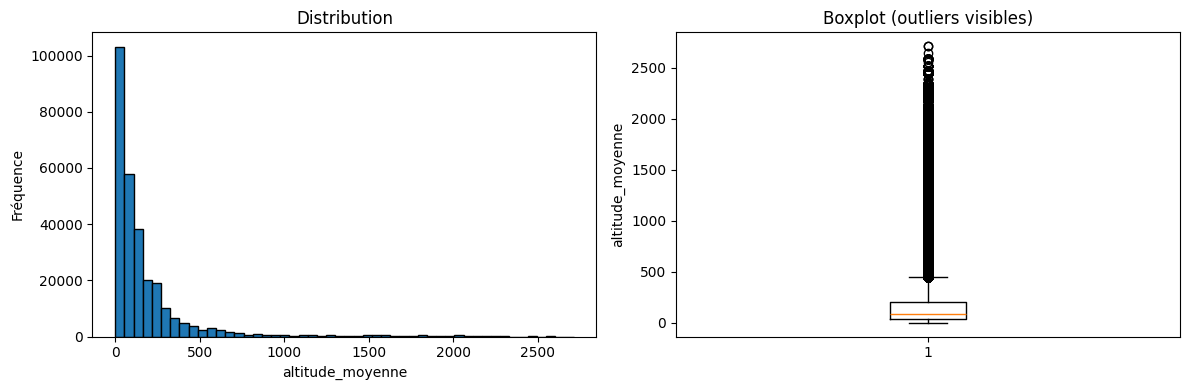

Visualisation des outliers pour la variable latitude_centre

Min: 42.35599899291992, Max: 51.073001861572266
Médiane: 46.98400115966797, Moyenne: 46.67278028913072


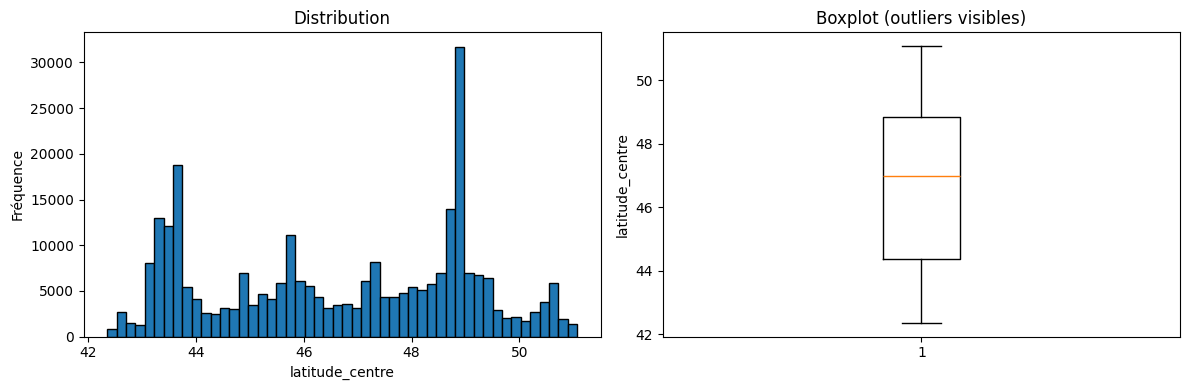

Visualisation des outliers pour la variable longitude_centre

Min: -5.085000038146973, Max: 7.651999950408936
Médiane: 2.444999933242798, Moyenne: 2.5342527755395614


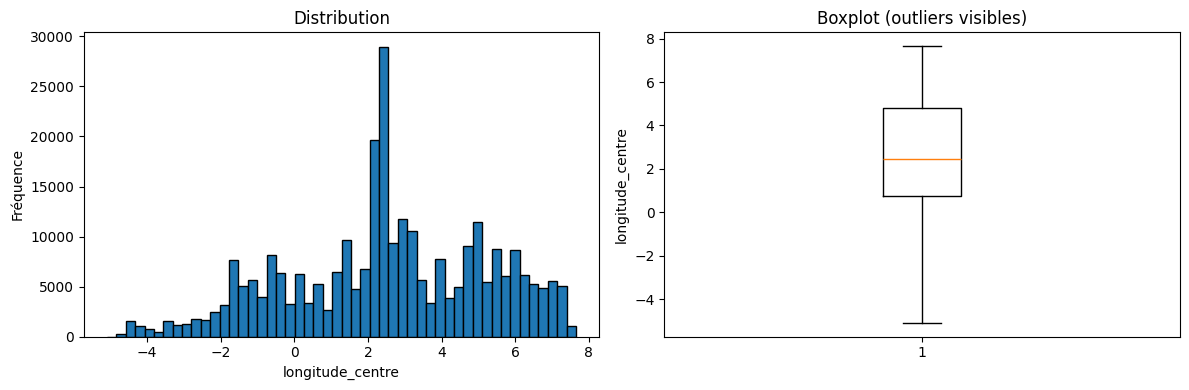

Visualisation des outliers pour la variable niveau_equipements_services

Min: 0.0, Max: 4.0
Médiane: 3.0, Moyenne: 2.4897937002131716


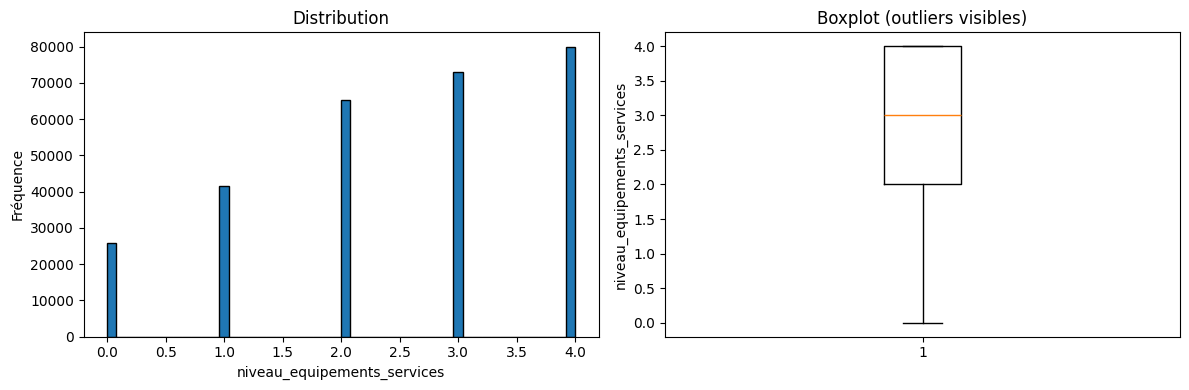

In [ ]:
for col in df_merged.drop(columns=['Code insee']):
    visu_outliers(df_merged[col])

In [14]:
import numpy as np

def traiter_outliers(df, cols=None, iqr_multiplier=1.5, drop=True, verbose=True):
    """
    Détecte et retire les outliers par colonne en utilisant la méthode IQR.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame d'entrée.
    cols : list or None
        Liste de colonnes à traiter. Si None, on prend les colonnes numériques.
    iqr_multiplier : float
        Multiplicateur IQR (1.5 par défaut).
    drop : bool
        Si True, retourne un nouveau DataFrame sans les lignes outliers. Si False, retourne le masque booléen des outliers.
    verbose : bool
        Affiche un résumé par colonne.

    Returns
    -------
    pd.DataFrame or pd.Series
        DataFrame nettoyé si drop=True sinon Series bool (True = outlier).
    """

    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if len(cols) == 0:
        if verbose:
            print("Aucune colonne numérique trouvée pour détecter les outliers.")
        return df.copy() if drop else pd.Series(False, index=df.index)

    # masque global qui sera True pour les lignes considérées outliers sur au moins une colonne
    outlier_mask = pd.Series(False, index=df.index)

    for col in cols:
        # calculs robustes en ignorant les NaN
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR

        mask = (df[col] < lower) | (df[col] > upper)
        outlier_mask = outlier_mask | mask

        if verbose:
            n_out = int(mask.sum())
            pct = 100 * n_out / len(df)
            print(f"Colonne '{col}': outliers = {n_out} / {len(df)} ({pct:.2f}%) | bounds=({lower:.2f}, {upper:.2f})")

    if drop:
        df_clean = df.loc[~outlier_mask].reset_index(drop=True)
        if verbose:
            print(f"\nTotal lignes supprimées : {int(outlier_mask.sum())} / {len(df)} ({100*outlier_mask.sum()/len(df):.2f}%)")
        return df_clean
    else:
        return outlier_mask

# Exemple d'utilisation :
# df_merged_clean = traiter_outliers(df_merged)
# ou pour obtenir le masque : mask = traiter_outliers(df_merged, drop=False)

print(len(df_merged))
df_merged_clean = traiter_outliers(df_merged)
print(len(df_merged_clean))

285216
Colonne 'Valeur fonciere': outliers = 17999 / 285216 (6.31%) | bounds=(-148755.62, 541259.38)
Colonne 'Surface reelle bati': outliers = 11762 / 285216 (4.12%) | bounds=(-23.50, 172.50)
Colonne 'Nombre pieces principales': outliers = 2189 / 285216 (0.77%) | bounds=(-1.00, 7.00)
Colonne 'Surface terrain': outliers = 14631 / 285216 (5.13%) | bounds=(-600.00, 1000.00)
Colonne 'population': outliers = 36606 / 285216 (12.83%) | bounds=(-74342.00, 132770.00)
Colonne 'superficie_km2': outliers = 29766 / 285216 (10.44%) | bounds=(-45.50, 102.50)
Colonne 'densite': outliers = 20953 / 285216 (7.35%) | bounds=(-3376.00, 6008.00)
Colonne 'altitude_moyenne': outliers = 23825 / 285216 (8.35%) | bounds=(-210.00, 446.00)
Colonne 'latitude_centre': outliers = 0 / 285216 (0.00%) | bounds=(37.64, 55.55)
Colonne 'longitude_centre': outliers = 0 / 285216 (0.00%) | bounds=(-5.36, 10.92)
Colonne 'niveau_equipements_services': outliers = 0 / 285216 (0.00%) | bounds=(-1.00, 7.00)

Total lignes supprimées

Visualisation des outliers pour la variable Valeur fonciere

Min: 5, Max: 541000
Médiane: 160000.0, Moyenne: 181542.38378155467


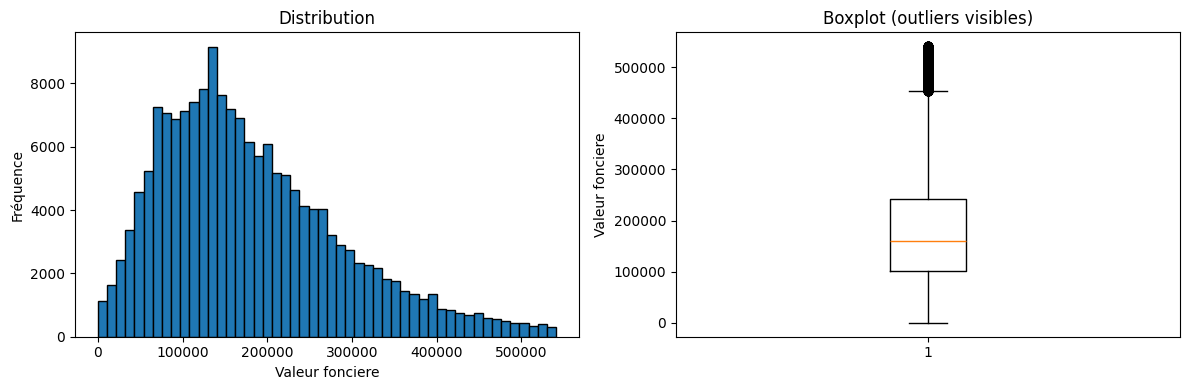

Visualisation des outliers pour la variable Surface reelle bati

Min: 1, Max: 172
Médiane: 74.0, Moyenne: 76.06265869392324


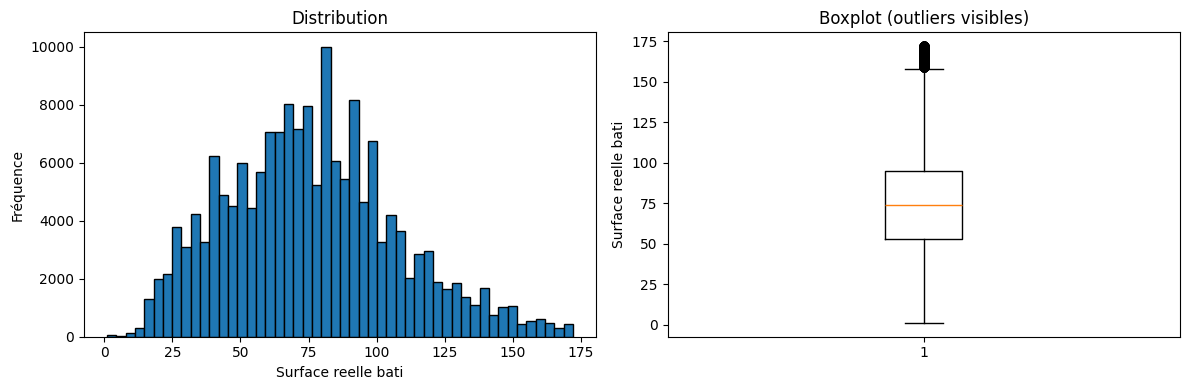

Visualisation des outliers pour la variable Nombre pieces principales

Min: 0, Max: 7
Médiane: 3.0, Moyenne: 3.3086158649739317


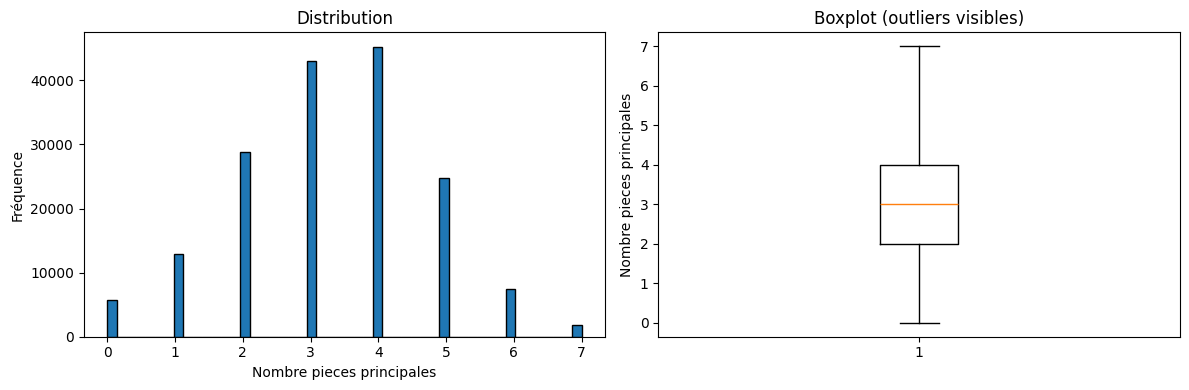

Visualisation des outliers pour la variable Surface terrain

Min: 0, Max: 1000
Médiane: 86.0, Moyenne: 225.07613184482605


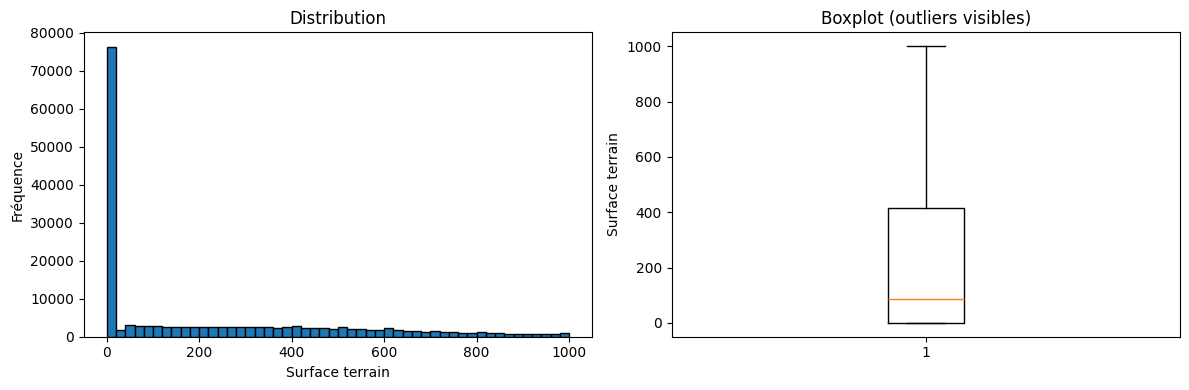

Visualisation des outliers pour la variable population

Min: 18, Max: 129760
Médiane: 9158.0, Moyenne: 20084.489681581195


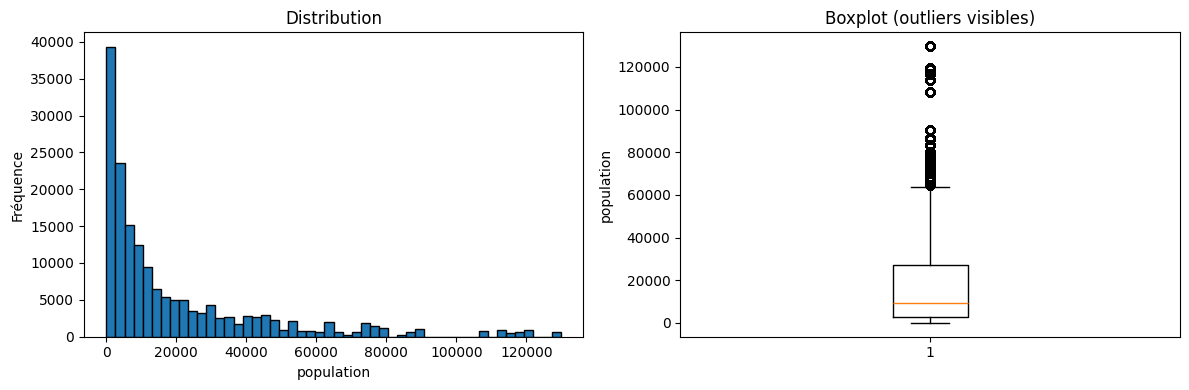

Visualisation des outliers pour la variable superficie_km2

Min: 0.0, Max: 102.0
Médiane: 16.0, Moyenne: 23.107442104332968


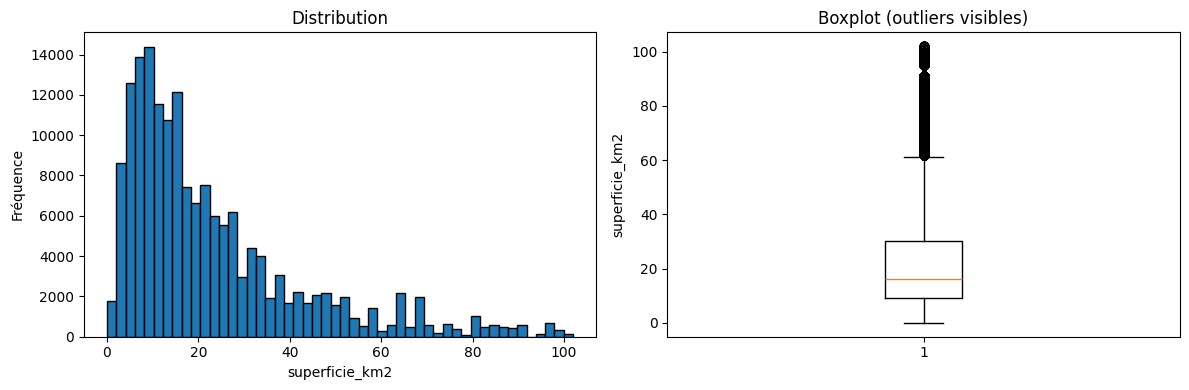

Visualisation des outliers pour la variable densite

Min: 2.0, Max: 5857.0
Médiane: 579.0, Moyenne: 1150.4713498717813


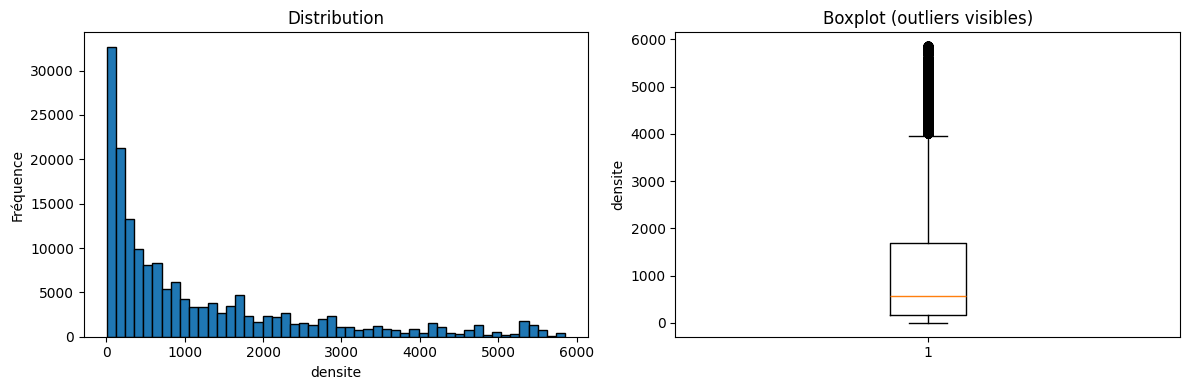

Visualisation des outliers pour la variable altitude_moyenne

Min: 0, Max: 446
Médiane: 88.0, Moyenne: 120.39688356063508


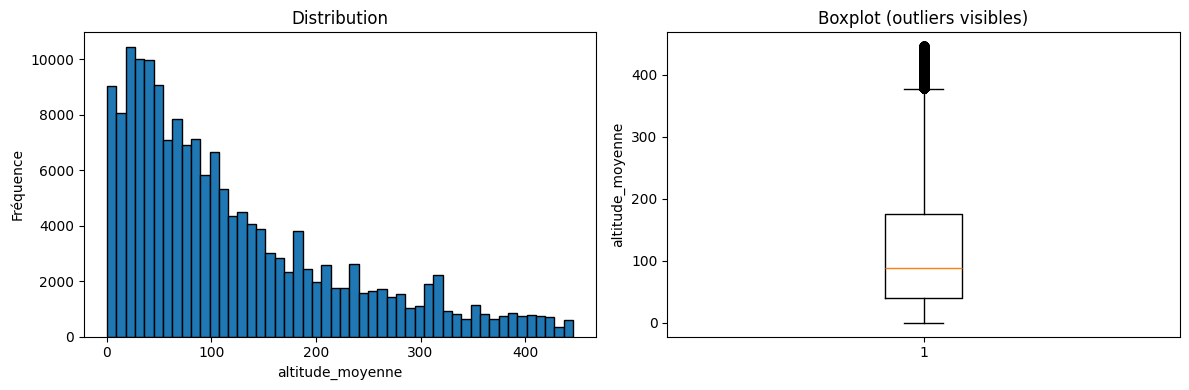

Visualisation des outliers pour la variable latitude_centre

Min: 42.444000244140625, Max: 51.073001861572266
Médiane: 47.255001068115234, Moyenne: 46.822582654657474


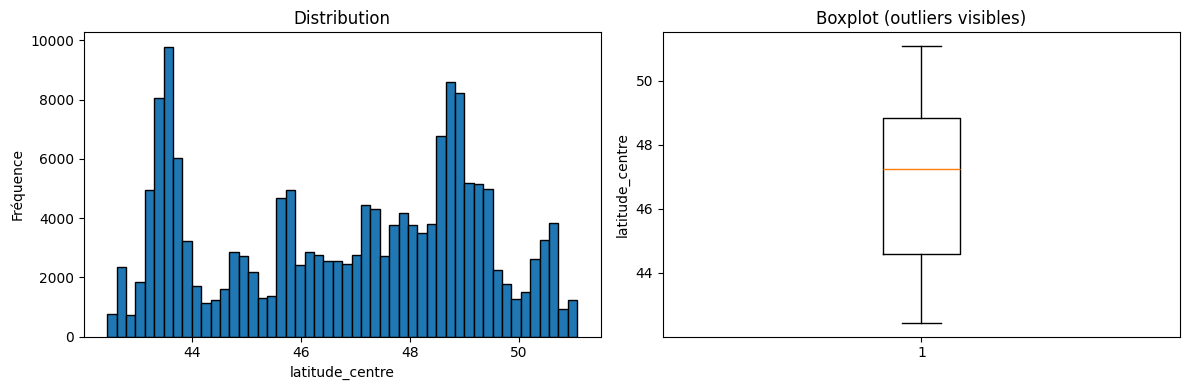

Visualisation des outliers pour la variable longitude_centre

Min: -5.085000038146973, Max: 7.49399995803833
Médiane: 2.3489999771118164, Moyenne: 2.1429170844096563


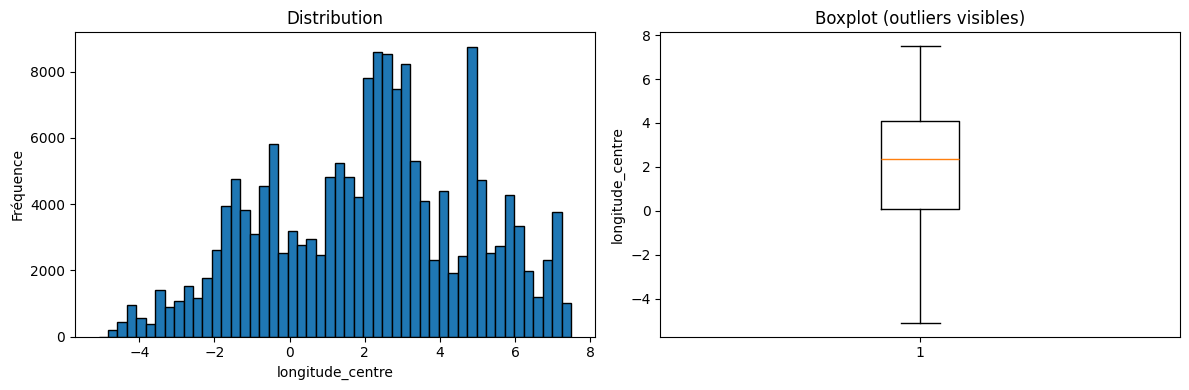

Visualisation des outliers pour la variable niveau_equipements_services

Min: 0.0, Max: 4.0
Médiane: 2.0, Moyenne: 2.2245191316386346


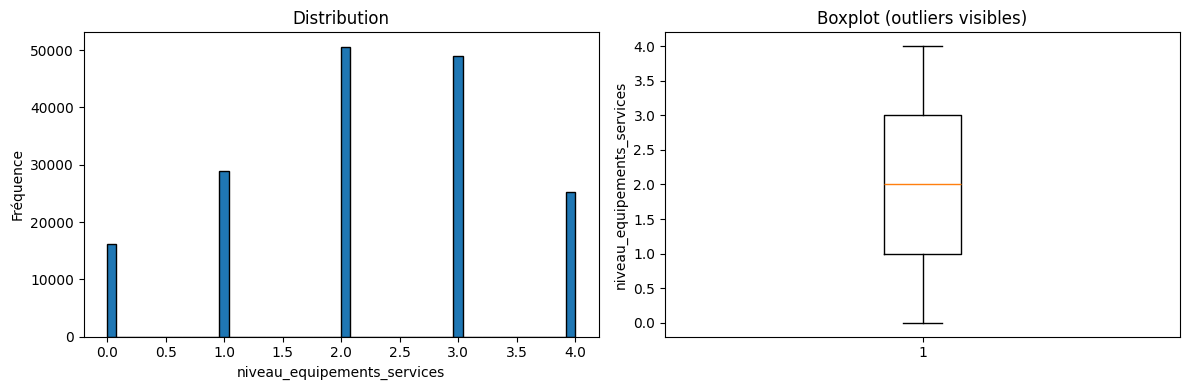

In [21]:
for col in df_merged_clean.drop(columns=['Code insee']):
    visu_outliers(df_merged_clean[col])

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

y = df_merged_clean['Valeur fonciere']
X = df_merged_clean.drop(columns=['Valeur fonciere', 'Code insee', ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

mlflow.set_tracking_uri("file://" + os.path.join(os.getcwd(), "mlruns"))
mlflow.set_experiment("mon_experience_immobilier")

with mlflow.start_run():
    # On lance l'entraînement du modèle a travers un run mlflow.
    # Pour visualiser les résultats, lancer la commande "mlflow ui" dans un terminal
    # Puis aller à l'adresse http://localhost:5000

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(random_state=42, learning_rate=0.1, n_estimators=100, max_depth=3))
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_valid)

    r2 = r2_score(y_valid, preds)

    # Logger les paramètres et métriques
    mlflow.log_param("model_type", "GradientBoostingRegressor")
    mlflow.log_metric("R2", r2)

    # Sauvegarder le modèle
    mlflow.sklearn.log_model(model, "model")

print(f"GradientBoostingRegressor : R2={r2:.4f}")


with mlflow.start_run():
    # On lance l'entraînement du modèle a travers un run mlflow.
    # Pour visualiser les résultats, lancer la commande "mlflow ui" dans un terminal
    # Puis aller à l'adresse http://localhost:5000
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_valid)

    r2 = r2_score(y_valid, preds)

    # Logger les paramètres et métriques
    mlflow.log_param("model_type", "XGBRegressor")
    mlflow.log_metric("R2", r2)
    
    # Sauvegarder le modèle
    mlflow.sklearn.log_model(model, "model")
print(f"XGBRegressor : R2={r2:.4f}")

